In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.signal import savgol_filter
import pandas as pd
import glob
import cv2

### Visualize Image

In [61]:
def visualize_image(path):
    image = plt.imread(path + '/01.bmp')
    plt.imshow(image, cmap = 'gray')
    plt.yticks([])
    plt.xticks([])
    plt.title("Image")


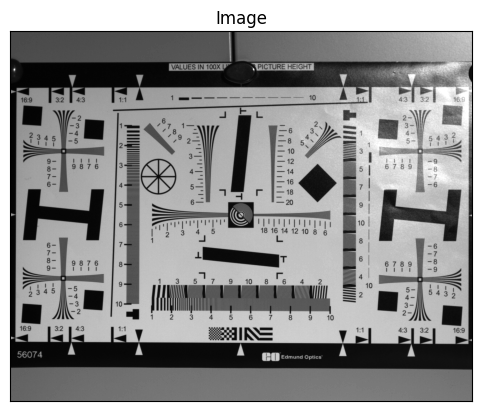

In [62]:
visualize_image("Visualization")

### Visualize MTF of Fixed ROIs

In [63]:
def visualize_image_ROI(path):
    image = plt.imread(path + '/01.bmp')
    roi_bounds = pd.read_csv(path + '/ROI_bounds.csv', )
    
    colors = ['red', 'blue', 'yellow', 'green', 'purple']
    plt.imshow(image, cmap = 'gray')
    for i in roi_bounds.index:
        plt.gca().add_patch(patches.Rectangle((roi_bounds.iloc[i][0],roi_bounds.iloc[i][1]),
                                            roi_bounds.iloc[i][2],roi_bounds.iloc[i][3],
                                            linewidth=1,edgecolor=colors[i],facecolor='none'))
    plt.xticks([])
    plt.yticks([])
    plt.title("Image with pre-selected ROIs")
    plt.show()

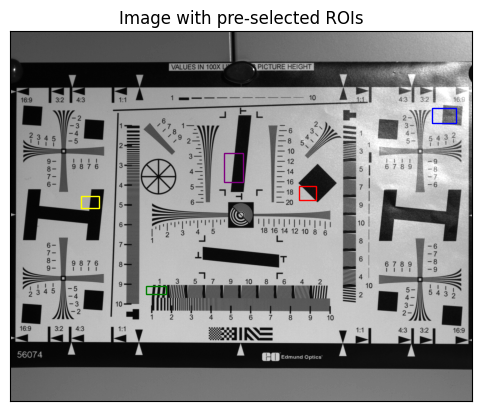

In [64]:
visualize_image_ROI('Visualization')

#### Functions

In [65]:
def MTF_process(ROI, output, filtered):
    ESF = ROI.mean(axis = 0)
    if filtered == 'yes':
        ESF = savgol_filter(ESF, 5, 1)
    LSF = np.abs(np.diff(ESF))

    MTF = np.abs(np.fft.fft(LSF))
    MTF = MTF[:]/np.max(MTF)
    MTF = MTF[:len(MTF)//2]

    if output == 'ESF': return np.array(ESF)
    if output == 'LSF': return np.array(LSF)
    if output == 'MTF': return np.array(MTF)

In [66]:
def MTF_process_individual(ROI, output, filtered):
    ESF_vals = []
    LSF_vals = []
    MTF_vals = []
    for i in range(len(ROI)):
        ESF = ROI[i]
        if filtered == 'yes':
            ESF = savgol_filter(ESF, 5, 1)
        LSF = np.abs(np.diff(ESF))
        
        MTF = np.abs(np.fft.fft(LSF))
        MTF = MTF[:]/np.max(MTF)
        MTF = MTF[:len(MTF)//2]

        ESF_vals.append(ESF)
        LSF_vals.append(LSF)
        MTF_vals.append(MTF)

    if output == 'ESF':
        return np.array(ESF_vals)
    if output == 'LSF':
        return np.array(LSF_vals)
    if output == 'MTF':
        return np.array(MTF_vals)
    


#### Visualize MTF of Pre-selected ROIs (using average of line scan)

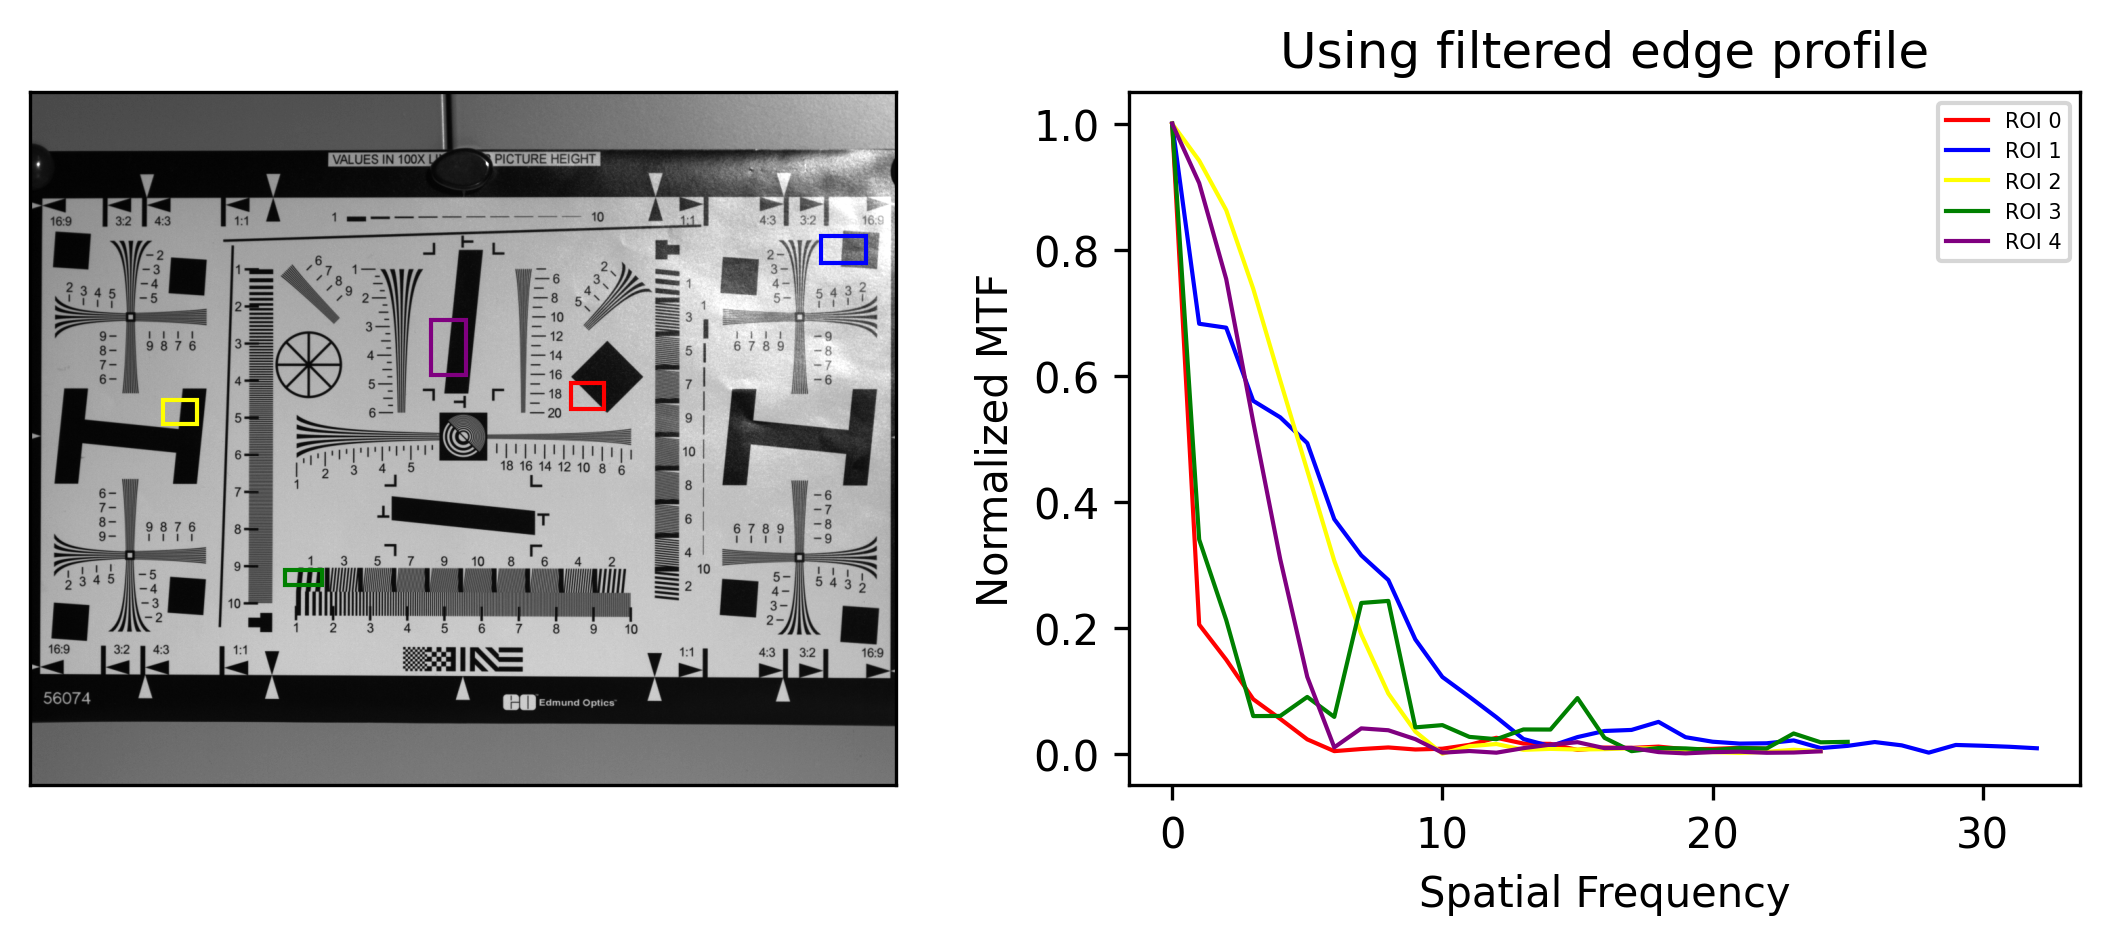

In [67]:
image = plt.imread('Visualization/01.bmp')
roi_bounds = pd.read_csv('Visualization/ROI_bounds.csv')
filtered_signal = str(input("Do you want to filter the line scan? (yes/no)"))

plt.figure(figsize = (6*1.5, 3), dpi = 300, facecolor = None)
colors = ['red', 'blue', 'yellow', 'green', 'purple']
plt.subplot(121)
plt.imshow(image, cmap = 'gray')
for i in roi_bounds.index:
    plt.gca().add_patch(patches.Rectangle((roi_bounds.iloc[i][0],roi_bounds.iloc[i][1]),
                                          roi_bounds.iloc[i][2],roi_bounds.iloc[i][3],
                                          linewidth=1,edgecolor=colors[i],facecolor='none'))
plt.xticks([])
plt.yticks([])

plt.subplot(122)
for i in roi_bounds.index:
    ROI = image[int(roi_bounds.iloc[i][1]):int(roi_bounds.iloc[i][1] + roi_bounds.iloc[i][3]), 
                int(roi_bounds.iloc[i][0]):int(roi_bounds.iloc[i][0] + roi_bounds.iloc[i][2])]
    
    MTF_vals = MTF_process(ROI, 'MTF', filtered_signal)
    #MTF_values_median = np.percentile(MTF_vals, 50, axis=0)
    
    plt.plot(np.arange(0, len(MTF_vals)), MTF_vals, color = colors[i], linewidth = 1, linestyle = 'solid', label = 'ROI ' + str(i))
    plt.ylabel('Normalized MTF')
    plt.xlabel('Spatial Frequency')
    plt.legend(fontsize = 5)
    if filtered_signal == 'yes': plt. title('Using filtered edge profile')
    if filtered_signal == 'no': plt. title('Using unfiltered edge profile')
plt.show()

#### Visualize MTF of Pre-selected ROIs (using individual line scans and average MTF)

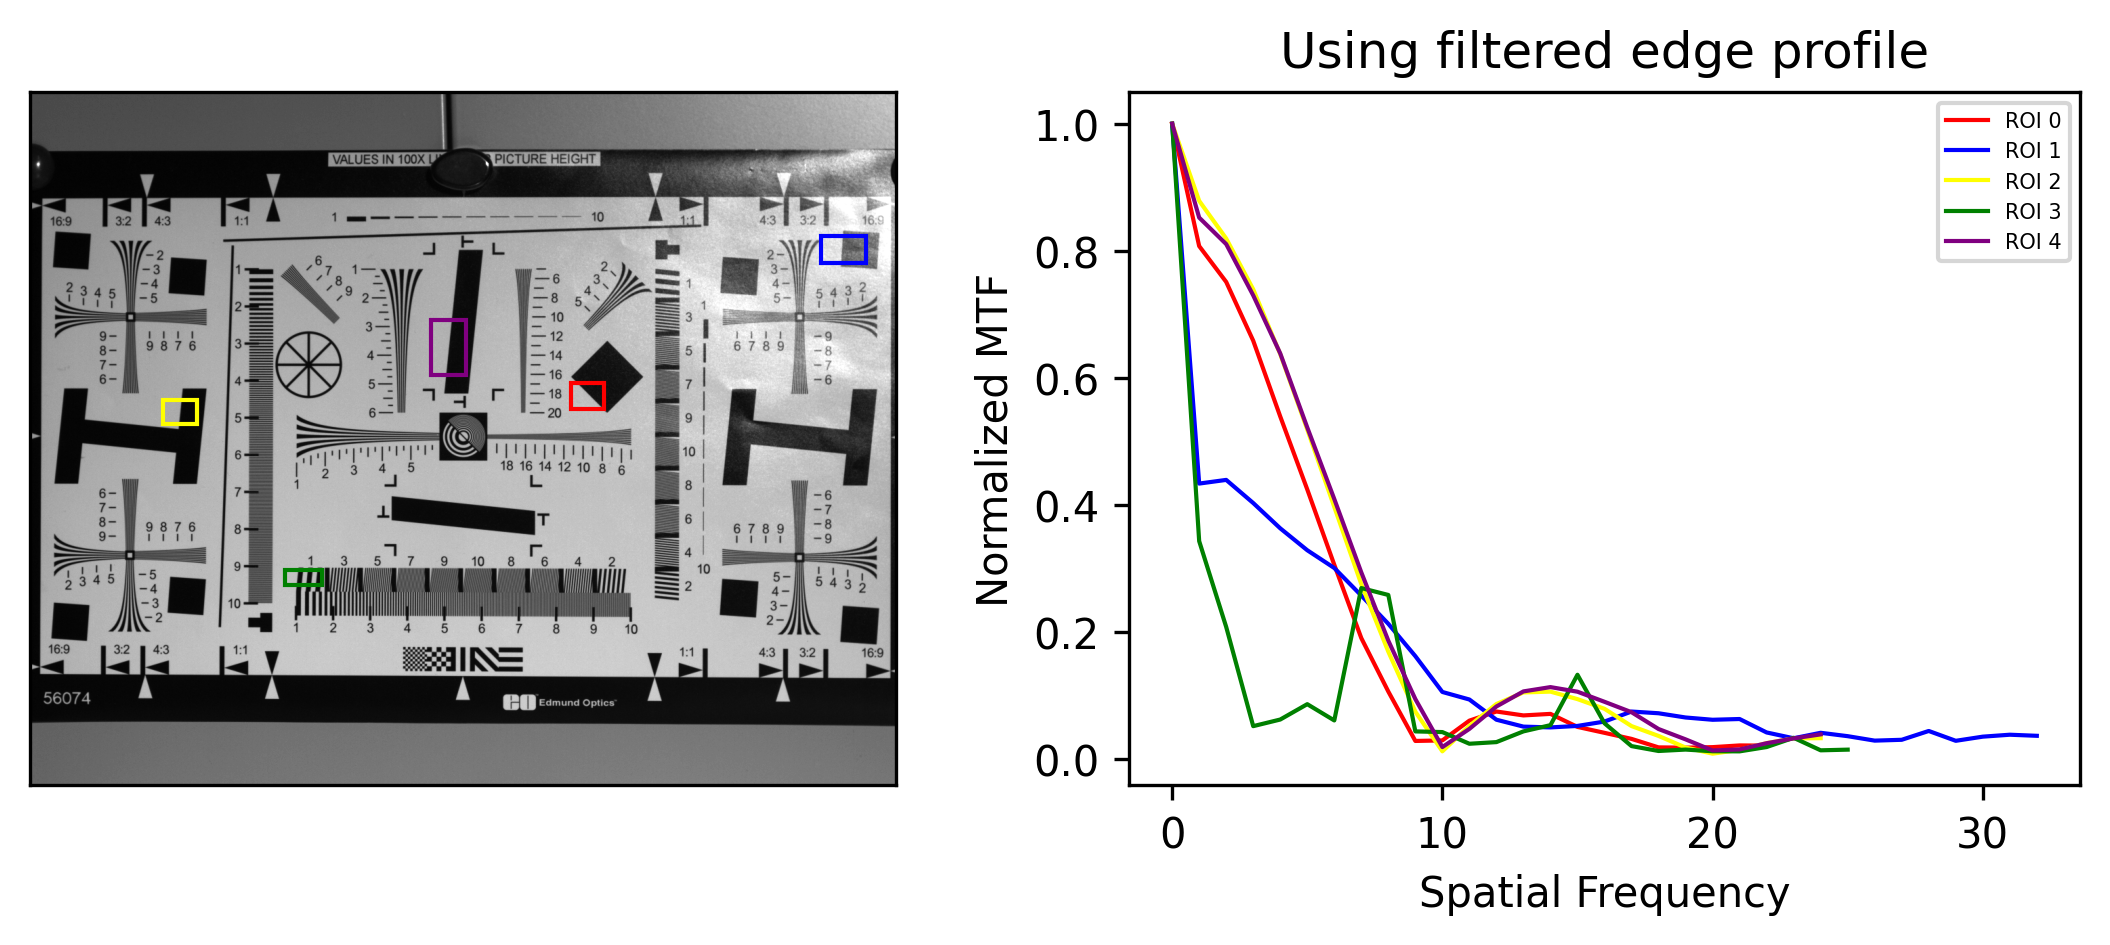

In [68]:
image = plt.imread('Visualization/01.bmp')
roi_bounds = pd.read_csv('Visualization/ROI_bounds.csv')
filtered_signal = str(input("Do you want to filter the line scan? (yes/no)"))

plt.figure(figsize = (6*1.5, 3), dpi = 300, facecolor = None)
colors = ['red', 'blue', 'yellow', 'green', 'purple']
plt.subplot(121)
plt.imshow(image, cmap = 'gray')
for i in roi_bounds.index:
    plt.gca().add_patch(patches.Rectangle((roi_bounds.iloc[i][0],roi_bounds.iloc[i][1]),
                                          roi_bounds.iloc[i][2],roi_bounds.iloc[i][3],
                                          linewidth=1,edgecolor=colors[i],facecolor='none'))
plt.xticks([])
plt.yticks([])

plt.subplot(122)
for i in roi_bounds.index:
    ROI = image[int(roi_bounds.iloc[i][1]):int(roi_bounds.iloc[i][1] + roi_bounds.iloc[i][3]), 
                int(roi_bounds.iloc[i][0]):int(roi_bounds.iloc[i][0] + roi_bounds.iloc[i][2])]
    
    MTF_vals = MTF_process_individual(ROI, 'MTF', filtered_signal)
    MTF_values_median = np.percentile(MTF_vals, 50, axis=0)
    
    plt.plot(np.arange(0, len(MTF_values_median)), MTF_values_median, color = colors[i], linewidth = 1, linestyle = 'solid', label = 'ROI ' + str(i))
    plt.ylabel('Normalized MTF')
    plt.xlabel('Spatial Frequency')
    plt.legend(fontsize = 5)
    if filtered_signal == 'yes': plt. title('Using filtered edge profile')
    if filtered_signal == 'no': plt. title('Using unfiltered edge profile')
plt.show()

### Create MTF of selected ROI

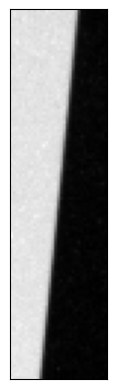

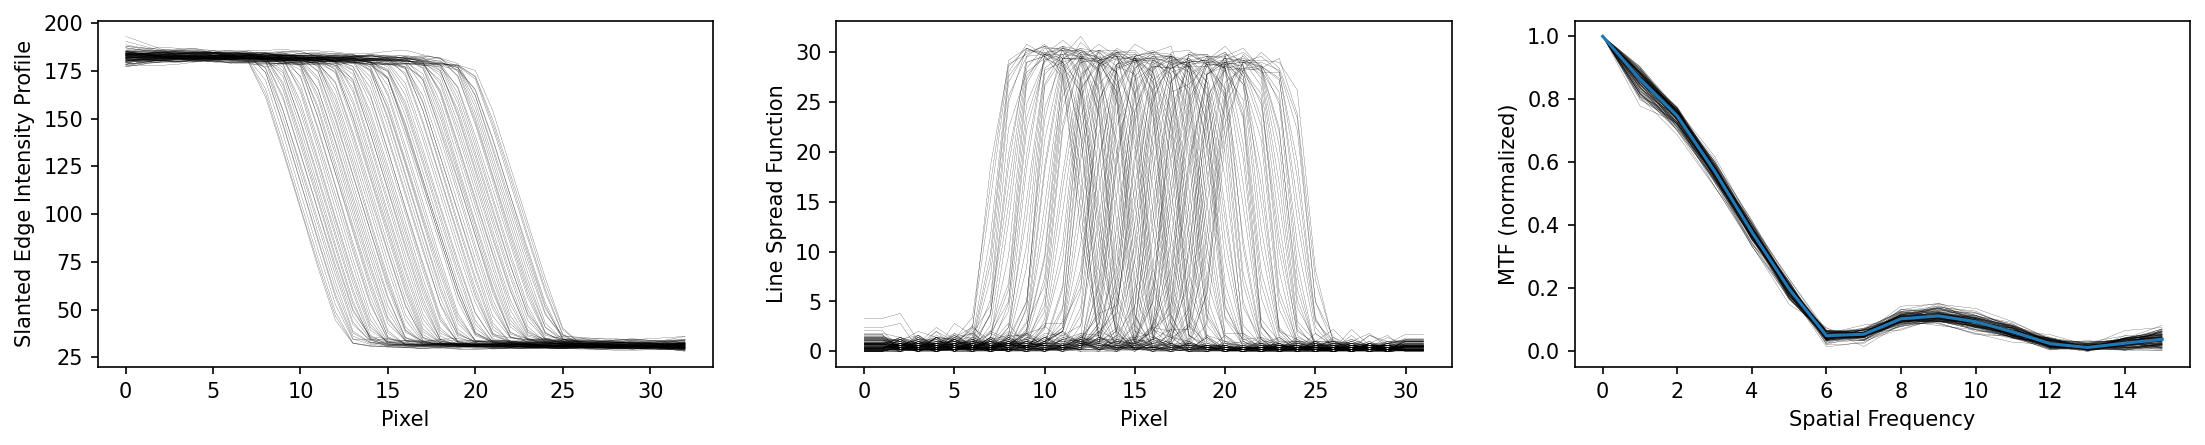

In [74]:
ROI_coords = cv2.selectROI(image)
ROI = image[int(ROI_coords[1]):int(ROI_coords[1] + ROI_coords[3]), int(ROI_coords[0]):int(ROI_coords[0] + ROI_coords[2])]
plt.imshow(ROI, cmap = "gray")
plt.xticks([])
plt.yticks([])

method = str(input("Which method to use? (individual/average)"))
filtered_signal = str(input("Do you want to filter the line scan? (yes/no)"))
width = 0.1

if method == "average":
    ESF = MTF_process(ROI, 'ESF', filtered_signal)
    LSF = MTF_process(ROI, 'LSF', filtered_signal)
    MTF = MTF_process(ROI, 'MTF', filtered_signal)

    plt.figure(figsize = (6*3,3), dpi = 150)
    plt.subplot(131)
    plt.plot(ESF, 'k.-', linewidth = width)
    plt.ylabel('Slanted Edge Intensity Profile')
    plt.xlabel('Pixel')

    plt.subplot(132)
    plt.plot(LSF, 'k.-', linewidth = width)
    plt.ylabel('Line Spread Function')
    plt.xlabel('Pixel')

    plt.subplot(133)
    plt.plot(MTF, 'k.-', linewidth = width)
    plt.ylabel('MTF (normalized)')
    plt.xlabel('Spatial Frequency')
    plt.show()

if method == "individual":
    ESF_v = MTF_process_individual(ROI, 'ESF', filtered_signal)
    LSF_v = MTF_process_individual(ROI, 'LSF', filtered_signal)
    MTF_v = MTF_process_individual(ROI, 'MTF', filtered_signal)

    plt.figure(figsize = (6*3,3), dpi = 150)
    plt.subplot(131)
    for ESF in ESF_v:
        plt.plot(ESF, 'k-', linewidth = width)
    plt.ylabel('Slanted Edge Intensity Profile')
    plt.xlabel('Pixel')

    plt.subplot(132)
    for LSF in LSF_v:
        plt.plot(LSF, 'k-', linewidth = width)
    plt.ylabel('Line Spread Function')
    plt.xlabel('Pixel')

    plt.subplot(133)
    for MTF in MTF_v:
        plt.plot(MTF, 'k-', linewidth = width)
    plt.plot(np.percentile(MTF_v, 50, axis = 0))
    plt.ylabel('MTF (normalized)')
    plt.xlabel('Spatial Frequency')
    plt.show()
